In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense,Flatten,Lambda,Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Making root .kaggle and shifting api file

!mkdir /root/.kaggle
!mv /content/kaggle.json /root/.kaggle
!chmod 777 root/.kaggle/kaggle.json

# Download the dataset using the Kaggle API
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images


chmod: cannot access 'root/.kaggle/kaggle.json': No such file or directory
100% 1.76G/1.76G [00:16<00:00, 92.2MB/s]
100% 1.76G/1.76G [00:17<00:00, 106MB/s] 


In [ ]:
# Unzip the downloaded dataset
!unzip /content/lung-and-colon-cancer-histopathological-images.zip -d /tmp

Streaming output truncated to the last 5000 lines.
  inflating: /tmp/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: /tmp/lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: /tmp/lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: /tmp/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: /tmp/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: /tmp/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: /tmp/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: /tmp/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: /tmp/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: /tmp/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: /tmp/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: /tmp/lung_colon_image_set/lun

In [ ]:
# Create directories for train, validation, and test data
!mkdir proj

In [ ]:
!pip install split-folders
!split_folders /tmp/lung_colon_image_set/lung_image_sets --ratio 0.8 0.1 0.1 --output /proj/


Copying files: 15000 files [00:03, 4374.43 files/s]


In [ ]:
from keras.applications.vgg19 import VGG19,preprocess_input
train_path='/proj/train'
val_path='/proj/val'

basemodel = VGG19(input_shape=(224,224,3),include_top=False)

# don't train existing weights
for layer in basemodel.layers:
  layer.trainable = False

In [ ]:
import os

# Define the path to the folder you want to count subfolders in
folder_path = '/proj/train'
# Get a list of all items (files and subdirectories) in the specified folder
items = os.listdir(folder_path)

# Use a list comprehension to filter only subdirectories from the items list
subfolders = [item for item in items if os.path.isdir(os.path.join(folder_path, item))]

# Count the number of subfolders
classes = len(subfolders)

print("Number of classes in the folder:", classes)


Number of classes in the folder: 3


In [ ]:
from keras.models import Model
from keras.layers import Flatten, Dense,BatchNormalization,Dropout
# our layers - you can add more if you want

x = Flatten()(basemodel.output)
x = Dense(512, activation='relu')(x)
x = Dense(classes, activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=basemodel.input, outputs=x)


In [ ]:
# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_image_gen=ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,
                             shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_image_gen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',shuffle=True)


val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',shuffle=True )

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
earlystop=EarlyStopping(patience=10)
learning_rate_reduction= ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5,min_lr=0.00001)
callbacks=[earlystop,learning_rate_reduction]

In [ ]:
# fit the model
history = model.fit(
  training_set,
  validation_data=val_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set),callbacks=callbacks
)

Epoch 1/10
188/188 [==============================] - 243s 1s/step - loss: 0.4908 - accuracy: 0.8765 - val_loss: 0.1337 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 225s 1s/step - loss: 0.1905 - accuracy: 0.9240 - val_loss: 0.1255 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 227s 1s/step - loss: 0.1500 - accuracy: 0.9414 - val_loss: 0.0925 - val_accuracy: 0.9580 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 226s 1s/step - loss: 0.1441 - accuracy: 0.9421 - val_loss: 0.0848 - val_accuracy: 0.9687 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 221s 1s/step - loss: 0.1329 - accuracy: 0.9481 - val_loss: 0.0813 - val_accuracy: 0.9673 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9503
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 [==============================] - 223s 

Found 1500 images belonging to 3 classes.
1500/1500 [==============================] - 18s 11ms/step
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       500
           1       1.00      0.99      0.99       500
           2       0.93      0.99      0.96       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



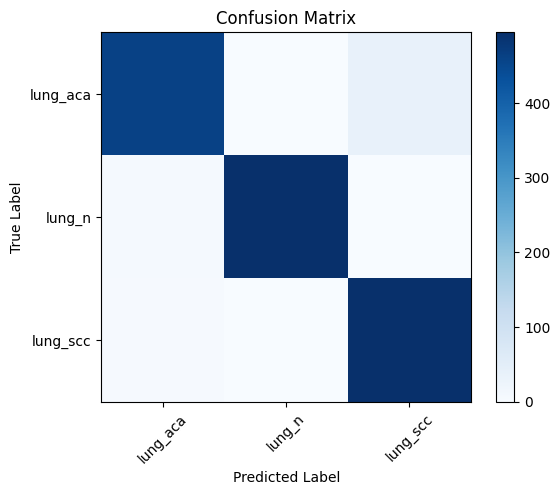

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model


# Creating an ImageDataGenerator for test data
image_gen = ImageDataGenerator(rescale=1.0/255)

# Load test data from the directory
test_data_gen = image_gen.flow_from_directory(
    batch_size=1,
    directory='/proj/test',
    shuffle=False,
    target_size=(224, 224),
    class_mode='categorical'
)

# Getting the true labels and predicted labels for the test data
y_true = test_data_gen.classes
num_samples = len(test_data_gen)
y_pred = model.predict(test_data_gen, steps=num_samples, verbose=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred_labels)

# Print the classification report
print(classification_report(y_true, y_pred_labels))

# Plot the confusion matrix as a heatmap
classes = list(test_data_gen.class_indices.keys())
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/TrainedModel/lungcancer.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Loading the pre-trained model
model = load_model('/content/drive/MyDrive/TrainedModel/lungcancer.h5')

In [ ]:
import tensorflow as tf


h5_model_path = '/content/drive/MyDrive/TrainedModel/lungcancer.h5'
model = tf.keras.models.load_model(h5_model_path)

# Convert to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_op = converter.convert()

# Save TFLite model to Google Drive
tflite_model_path = '/content/drive/MyDrive/TrainedModel/model_self_op.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model_op)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import tensorflow as tf

# Creating an ImageDataGenerator for test data
image_gen = ImageDataGenerator(rescale=1.0/255)
# Load test data from the directory
test_data_gen = image_gen.flow_from_directory(
    batch_size=1,
    directory='/proj/test',
    shuffle=False,
    target_size=(224, 224),
    class_mode='categorical'
)

# Calculate the number of samples in the test dataset
num_samples = len(test_data_gen)

Found 1500 images belonging to 3 classes.


              precision    recall  f1-score   support

           0       0.91      0.96      0.93       500
           1       1.00      1.00      1.00       500
           2       0.96      0.91      0.93       500

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



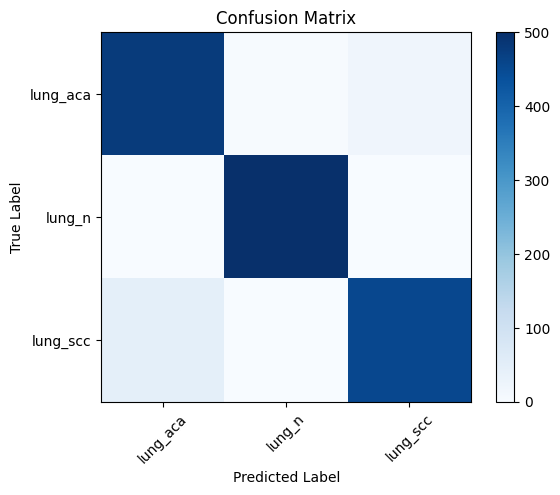

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/TrainedModel/model_self_op.tflite')
interpreter.allocate_tensors()

# Get the input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Create an empty array to store the predictions
y_pred_labels = []


# Convert the true labels to a numpy array
y_true = test_data_gen.classes
y_true = np.array(y_true)


# Run predictions on the test data
for i in range(num_samples):
    test_image, _ = test_data_gen[i]  # Get one sample from the test data generator
    input_data = np.array(test_image, dtype=np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    # Get the prediction and convert it to class label
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output_data, axis=1)[0]
    y_pred_labels.append(predicted_label)



# Compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred_labels)

# Print the classification report
print(classification_report(y_true, y_pred_labels, zero_division=1))

# Plot the confusion matrix as a heatmap
classes = list(test_data_gen.class_indices.keys())
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
